In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import os
import sys
from tqdm.auto import tqdm
from time_series import create_time_series
sys.path.insert(0, os.path.abspath("../fsrs-optimizer/src/fsrs_optimizer/"))
import fsrs_optimizer
import plotly.express as px
import numpy as np

tqdm.pandas()

In [2]:
# Median: 8798
# Most: 6810

df = pd.read_parquet(
    "../anki-revlogs-10k/revlogs", filters=[("user_id", "=", 432)] 
)

In [3]:
df.drop(df[~df["rating"].isin([1, 2, 3, 4])].index, inplace=True)

In [4]:
df

,card_id,day_offset,rating,state,duration,elapsed_days,elapsed_seconds,user_id
54173,4284,0,1,0,23628,-1,-1,432
54155,4281,0,1,0,15172,-1,-1,432
54145,4278,0,1,0,15932,-1,-1,432
54083,4261,0,3,0,7388,-1,-1,432
54250,4298,0,3,0,11493,-1,-1,432
...,...,...,...,...,...,...,...,...
70199,6122,3271,3,0,12992,-1,-1,432
70194,6117,3271,3,0,1614,-1,-1,432
70196,6119,3271,3,0,737,-1,-1,432
70198,6121,3271,3,0,727,-1,-1,432


In [5]:
df[df["card_id"] == 230]

,card_id,day_offset,rating,state,duration,elapsed_days,elapsed_seconds,user_id
1664,230,2018,1,0,10598,-1,-1,432
1665,230,2018,1,1,7486,0,69,432
1666,230,2018,3,1,3907,0,3401,432
1667,230,2018,3,1,3759,0,210,432
1668,230,2019,3,2,5594,1,87209,432
1669,230,2023,3,2,5443,4,388411,432
1670,230,2032,3,2,8158,9,770007,432
1671,230,2064,3,2,4661,32,2769527,432
1672,230,2162,3,2,4735,98,8472647,432
1673,230,2765,4,2,9859,603,52106559,432


In [6]:
df["prior_reviews"] = df.groupby("day_offset").cumcount()

In [7]:
print("creating time series")
df: pd.DataFrame = create_time_series(df)
print("training")
trainer = fsrs_optimizer.Trainer(df, df, fsrs_optimizer.DEFAULT_PARAMETER)
w = trainer.train()

creating time series
training


train:   0%|          | 0/42175 [00:00<?, ?it/s]

iteration: 4096
w: [0.3421, 1.153, 3.0807, 15.7282, 7.161, 0.514, 1.5225, 0.0021, 1.5606, 0.0949, 1.036, 1.8606, 0.1848, 0.2122, 2.1867, 0.1657, 3.0053, 0.4558, 0.6085]
iteration: 8192
w: [0.2576, 1.1142, 2.9861, 15.6968, 7.1499, 0.4946, 1.5307, 0.0287, 1.5804, 0.1114, 1.0618, 1.8642, 0.1709, 0.2113, 2.1829, 0.1634, 3.047, 0.4224, 0.5501]
iteration: 12288
w: [0.2308, 1.075, 2.9145, 15.6907, 7.1619, 0.4727, 1.5621, 0.0223, 1.5671, 0.1336, 1.0534, 1.9068, 0.124, 0.2508, 2.2183, 0.1712, 3.0754, 0.389, 0.5412]
iteration: 16384
w: [0.2426, 1.0571, 2.8911, 15.6918, 7.1534, 0.4704, 1.5745, 0.0179, 1.5731, 0.1476, 1.0624, 1.9419, 0.087, 0.2793, 2.2359, 0.1957, 3.115, 0.393, 0.5585]
iteration: 20480
w: [0.2367, 1.0326, 2.8473, 15.7165, 7.1489, 0.4777, 1.5983, 0.0173, 1.5782, 0.1395, 1.0695, 1.9241, 0.1044, 0.2604, 2.2096, 0.1945, 3.1574, 0.3395, 0.5597]
iteration: 24576
w: [0.2477, 1.0251, 2.8131, 15.7312, 7.1417, 0.4812, 1.6157, 0.0207, 1.5843, 0.1193, 1.0762, 1.9015, 0.1252, 0.2339, 2.1788, 0

In [8]:
import math

DECAY = -0.5
FACTOR = 0.9 ** (1 / DECAY) - 1

def power_forgetting_curve(t, s):
    return (1 + FACTOR * t / s) ** DECAY

def stability_after_success(s, r, d, rating):
    hard_penalty = w[15] if rating == 2 else 1
    easy_bonus = w[16] if rating == 4 else 1
    return max(
        0.01,
        s * (
            1
            + math.exp(w[8])
            * (11 - d)
            * (s ** -w[9])
            * (math.exp((1 - r) * w[10]) - 1)
            * hard_penalty
            * easy_bonus
        )
    )

def stability_after_failure(s, r, d):
    return max(
        0.01,
        min(
            w[11]
            * (d ** -w[12])
            * ((s + 1) ** w[13] - 1)
            * math.exp((1 - r) * w[14]),
            s / math.exp(w[17] * w[18])
        )
    )

def stability_short_term(s, init_rating=None):
    if init_rating is not None:
        rating_offset = fsrs_optimizer.DEFAULT_FIRST_RATING_OFFSETS[init_rating - 1]
        session_len = fsrs_optimizer.DEFAULT_FIRST_SESSION_LENS[init_rating - 1]
    else:
        rating_offset = fsrs_optimizer.DEFAULT_FORGET_RATING_OFFSET
        session_len = fsrs_optimizer.DEFAULT_FORGET_SESSION_LEN
    
    new_s = s * math.exp(
        w[17] * (rating_offset + session_len * w[18])
    )
    return new_s

def init_d(rating):
    return w[4] - math.exp(w[5] * (rating - 1)) + 1

def init_d_with_short_term(rating):
    rating_offset = fsrs_optimizer.DEFAULT_FIRST_RATING_OFFSETS[rating - 1]
    new_d = init_d(rating) - w[6] * rating_offset
    return max(1, min(new_d, 10))

def linear_damping(delta_d, old_d):
    return delta_d * (10 - old_d) / 9

def mean_reversion(target, value, alpha=0.5):
    return alpha * target + (1 - alpha) * value

def next_d(d, rating):
    delta_d = -w[6] * (rating - 3)
    new_d = d + linear_damping(delta_d, d)
    new_d = mean_reversion(init_d(4), new_d)
    return max(1, min(new_d, 10))


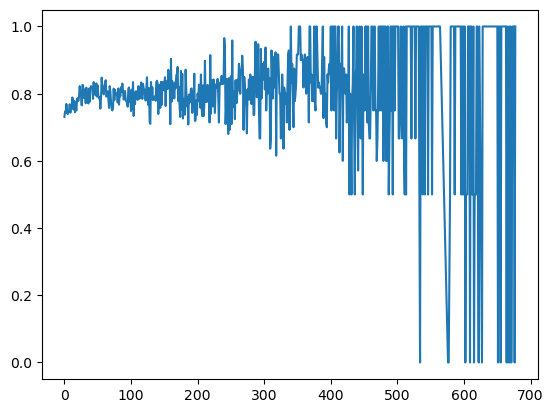

In [9]:
mean = df.groupby("prior_reviews")["y"].mean()
plt.plot(mean)
plt.show()

In [10]:
def memory_state(df):
    t_history = [int(t) for t in df["t_history"].split(",")]
    r_history = [int(r) for r in df["r_history"].split(",")]
    difficulty = None
    stability = None
    retrievability = None
    for delta_t, rating in zip(t_history, r_history):
        if stability is None:  # New card
            difficulty = init_d_with_short_term(rating)
            stability = stability_short_term(w[rating - 1], init_rating=rating)
        else:
            retrievability = power_forgetting_curve(delta_t, stability)
            if rating > 1:
                stability = stability_after_success(
                    stability, retrievability, difficulty, rating
                )
            else:
                stability = stability_after_failure(stability, retrievability, difficulty)
            difficulty = next_d(difficulty, rating)

    return stability, difficulty, retrievability


df["s"], df["d"], df["r"] = zip(*df.progress_apply(memory_state, axis=1))
df[df["r"] < 1]

  0%|          | 0/42175 [00:00<?, ?it/s]

,card_id,day_offset,rating,state,duration,elapsed_days,elapsed_seconds,user_id,prior_reviews,review_th,...,r_history,t_history,tensor,last_rating,y,first_rating,seq_len,s,d,r
54054,4253.0,65.0,4.0,1.0,1730.0,2.0,162968.0,432,10.0,199.0,...,"3,3","0,4","[[tensor(0), tensor(3)], [tensor(4), tensor(3)]]",3.0,1.0,3,2,12.964291,4.871311,0.878919
54082,4260.0,65.0,4.0,1.0,961.0,2.0,162995.0,432,13.0,202.0,...,"1,3","0,1","[[tensor(0), tensor(1)], [tensor(1), tensor(3)]]",3.0,1.0,1,2,1.665324,6.225548,0.742027
54302,4315.0,65.0,3.0,1.0,414.0,2.0,163003.0,432,15.0,204.0,...,"1,3","0,4","[[tensor(0), tensor(1)], [tensor(4), tensor(3)]]",3.0,1.0,1,2,3.478866,6.225548,0.484231
54315,4320.0,65.0,4.0,1.0,366.0,2.0,157967.0,432,18.0,207.0,...,"4,3","0,4","[[tensor(0), tensor(4)], [tensor(4), tensor(3)]]",3.0,1.0,4,2,27.004143,4.111068,0.971466
54139,4276.0,65.0,4.0,1.0,426.0,2.0,157786.0,432,21.0,210.0,...,"4,3","0,4","[[tensor(0), tensor(4)], [tensor(4), tensor(3)]]",3.0,1.0,4,2,27.004143,4.111068,0.971466
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68400,5846.0,3270.0,3.0,2.0,5085.0,5.0,389741.0,432,11.0,70121.0,...,"1,2,3,3,1,3,3,3,3,1,3,1,3,3,3","0,0,0,0,1,0,4,4,11,29,0,5,0,1,3","[[tensor(0), tensor(1)], [tensor(0), tensor(2)...",3.0,1.0,1,15,13.384705,4.267875,0.926316
69431,5991.0,3271.0,1.0,3.0,11521.0,1.0,81863.0,432,1.0,70126.0,...,"3,3,1,3,3,3,3,1","0,0,1,0,2,2,11,21","[[tensor(0), tensor(3)], [tensor(0), tensor(3)...",1.0,0.0,3,8,2.592394,5.216773,0.945875
69547,6004.0,3271.0,4.0,2.0,3247.0,22.0,1873237.0,432,6.0,70131.0,...,"3,3,3,3,3","0,0,2,2,11","[[tensor(0), tensor(3)], [tensor(0), tensor(3)...",3.0,1.0,3,5,43.695964,4.206099,0.923089
69589,6011.0,3271.0,3.0,2.0,8172.0,15.0,1263239.0,432,8.0,70133.0,...,"3,3,2,3,3,2","0,0,0,2,5,13","[[tensor(0), tensor(3)], [tensor(0), tensor(3)...",2.0,1.0,3,6,28.169900,4.737649,0.939172


In [11]:
df["loss"] = df.apply(lambda df: (df["y"] - df["r"]) ** 2, axis=1)

<Figure size 640x480 with 0 Axes>

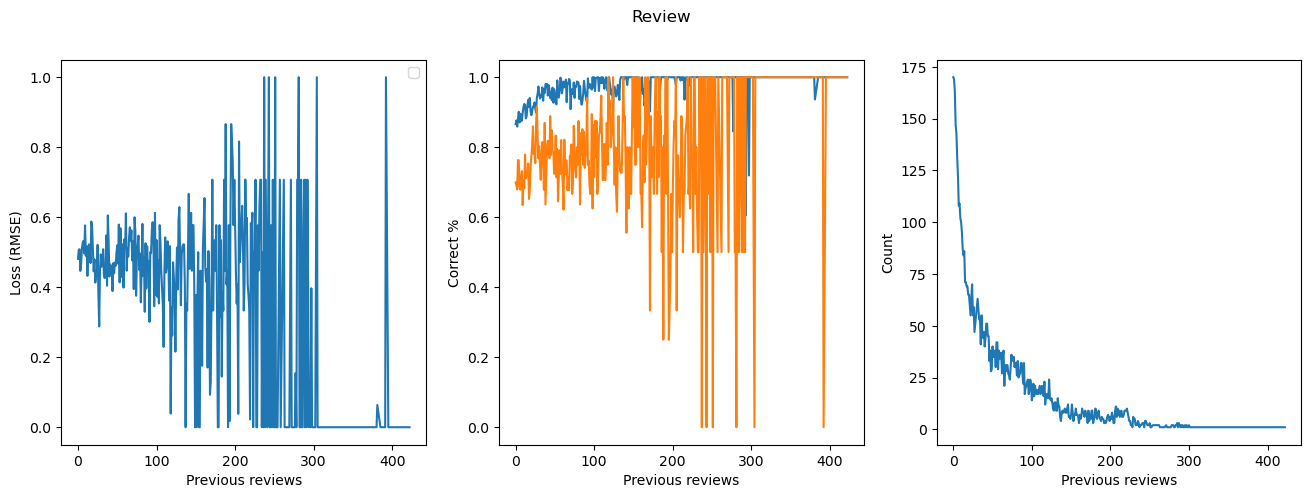

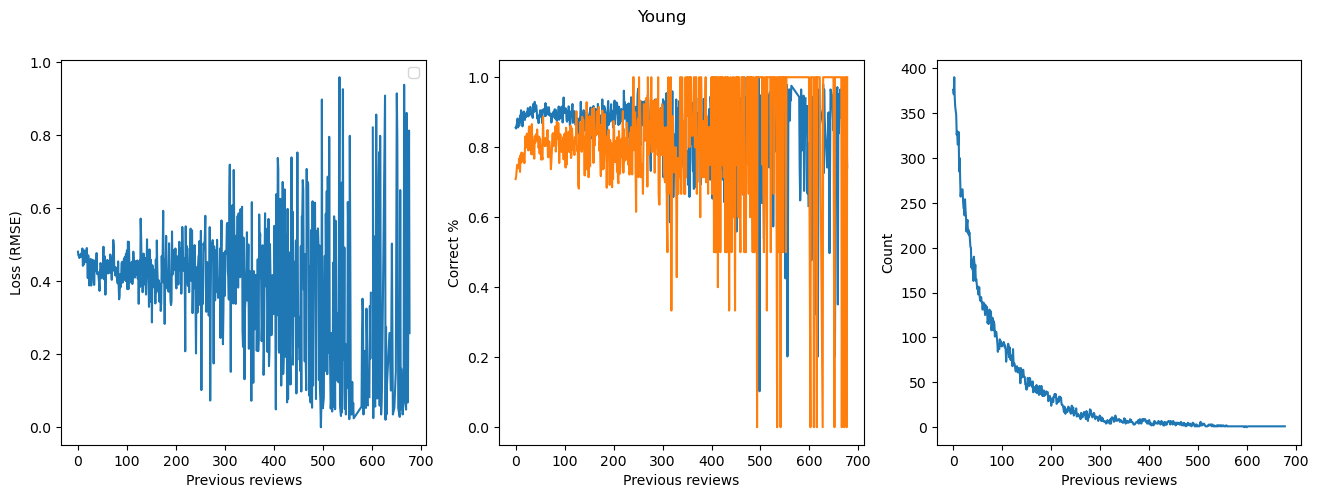

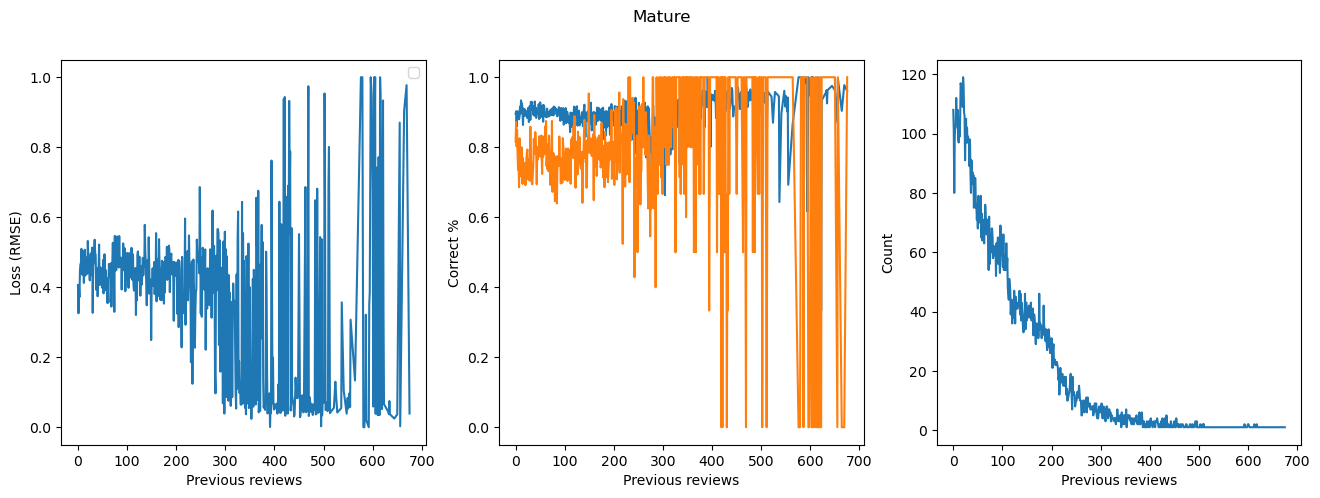

In [12]:
categories = [("Review", -1, 1), ("Young", 0, 21), ("Mature", 21, 1e20)]

plt.clf()

for name, lower, upper in categories:
    df_filtered = df[(df["elapsed_days"] > lower) & (df["elapsed_days"] <= upper)].groupby("prior_reviews")
    loss = df_filtered["loss"].mean() ** 0.5

    fig = plt.figure(figsize=(16, 5))
    fig.suptitle(name)
    ax1 = fig.add_subplot(131)

    ax1.set_xlabel('Previous reviews')
    ax1.set_ylabel('Loss (RMSE)')
    ax1.plot(loss)
    ax1.legend()

    ax2 = fig.add_subplot(132)

    ax2.plot(df_filtered["r"].mean())
    ax2.plot(df_filtered["y"].mean())
    ax2.set_xlabel('Previous reviews')
    ax2.set_ylabel('Correct %')

    ax3 = fig.add_subplot(133)

    ax3.plot(df_filtered["r"].count())
    ax3.set_xlabel('Previous reviews')
    ax3.set_ylabel('Count') # Number of days that the user had that many reviews or more

    plt.show()


In [14]:
fig = px.scatter_3d(df[(df["elapsed_days"] < 21) & (df["elapsed_days"] > 0)], x="prior_reviews", y="s", z="loss", range_y=(0, 21))
with open("out.html", "w") as f:
    f.write(fig.to_html())